# Determine opt-out rate for desktop improvements feature on test wikis

[Task](https://phabricator.wikimedia.org/T269664)

# Contents

1. [Purpose](#Purpose)
2. [Data](#Data)
2. [Overall Opt-Outs](#Overall-Opt-Outs)
4. [Opt-Outs by Test Wiki](#Opt-Outs-by-Test-Wiki)
4. [Opt-Outs by User Edit Count](#Opt-Outs-by-User-Edit-Count)



# Purpose

Determine percentage of logged-in users that have opted out from the new version of vector on the [early adopter wikis](https://www.mediawiki.org/wiki/Reading/Web/Desktop_Improvements#List_of_early_adopter_wikis_(test_wikis)):
* per test wiki
* per user edit bucket


# Data
A new schema, [mediawiki_pref_diff](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/pref_diff/current.yaml), was created in [T261842](https://phabricator.wikimedia.org/T261842) to track the opt-ins and opt-outs of desktop improvements and deployed on 8 April 2021. Unlike PrefUpdate, this schema logs an arbitrary `intial` and `final` state (e.g. a user switched from latest Vector to Monobook). It also allows for the use of a hashed user ID. 

The results of this analysis are based on data collected from 18 May 2021 through 15 July 2021. 

Data Caveats: 
* Instrumentation only allows us to confirm the intial state a user switched from. It does not provide information on the default skin that was first presented to the user. 
* Data only include switches that were initiated by the user.
* The new desktop skin is currently available as default on all test wikis; however, we do not have data on user preference changes that occured prior to 17 May 2021.
* The new vector skin was deployed as default to all users on the early adopter wikis at the following times: 
  * July 2020: Deployed as default to first set of early adopter wikis.
  * February 2021: Deployed as default to the second set of early adopter wikis.


In [4]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse); library(lubridate); library(scales)
})

In [5]:
options(repr.plot.width = 15, repr.plot.height = 15)

In [50]:
# opt out date from pref_diff
query <- 
"
-- find all users that optd in to the new vector
WITH opt_in_users AS (
    SELECT user_hash AS `user`,
    date_format(dt, 'yyyy-MM-dd') AS opt_in_time
FROM event.mediawiki_pref_diff
WHERE 
    year = 2021
-- first day full data was collected
    AND ((month = 05 and day >= 18) OR 
        (month = 06) OR 
        month = 07 and day < 15)
    AND final_state = 'vector2'
)
-- find all users that optd out of the old vector
SELECT
    date_format(dt, 'yyyy-MM-dd') AS opt_out_time,
    user_hash AS `user`,
    final_state AS final_state,
    min(bucketed_user_edit_count) AS edit_count,
    meta.domain as wiki,
-- find out if user optd back in 
    SUM(CAST(opt_in_users.`user` IS NOT NULL AND opt_in_users.opt_in_time > date_format(dt, 'yyyy-MM-dd') AS INT)) AS is_opt_back_in,
    COUNT(*) AS num_selections
FROM event.mediawiki_pref_diff
LEFT JOIN 
    opt_in_users ON user_hash = opt_in_users.`user`
WHERE 
    year = 2021
-- first day full data was collected
      AND ((month = 05 and day >= 18) OR 
        (month = 06) OR 
        (month = 07 and day < 15))
-- only users that opt'd out of modern vector
    AND initial_state = 'vector2'
GROUP BY
    date_format(dt, 'yyyy-MM-dd') ,
    user_hash,
    final_state,
    meta.domain
"

In [51]:
desktop_pref_updates <-  wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [52]:
modern_vector_opt_outs_pilot <- desktop_pref_updates %>%
 # only look at target wikis
    filter( wiki %in% c('fr.wiktionary.org', 'he.wikipedia.org', 'pt.wikiversity.org', 'fr.wikipedia.org', 
    'eu.wikipedia.org', 'fa.wikipedia.org', 'pt.wikipedia.org', 'ko.wikipedia.org', 'tr.wikipedia.org', 
                       'sr.wikipedia.org', 'bn.wikipedia.org', 'de.wikivoyage.org', 'vec.wikipedia.org')) 

In [53]:
#clean up
modern_vector_opt_outs_pilot <- modern_vector_opt_outs_pilot %>%
    mutate(
    wiki = case_when( #clarfiy Wiki project names
        wiki == 'eu.wikipedia.org' ~ "Basque Wikipedia",
        wiki == 'fr.wikipedia.org'~ "French Wikipedia",
        wiki == 'fr.wiktionary.org' ~ "French Wikitionary",
        wiki == 'he.wikipedia.org' ~ 'Hebrew Wikipedia',
        wiki == 'fa.wikipedia.org' ~ 'Persian Wikipedia',
        wiki == 'pt.wikiversity.org' ~ 'Portuguese Wikiversity',
        wiki == 'pt.wikipedia.org' ~ 'Portuguese Wikipedia',
        wiki == 'ko.wikipedia.org' ~ 'Korean Wikipedia',
        wiki == 'tr.wikipedia.org' ~ 'Turkish Wikipedia',
        wiki == 'sr.wikipedia.org' ~ 'Serbian Wikipedia',
        wiki == 'bn.wikipedia.org' ~ 'Bengali Wikipedia',
        wiki == 'de.wikivoyage.org' ~ 'German Wikivoyage',
        wiki == 'vec.wikipedia.org' ~ 'Venetian Wikipedia'),
# format edit count as factors and specify levels
        edit_count = factor(
            edit_count, 
            levels = c("0 edits", "1-4 edits", "5-99 edits", 
                       "100-999 edits", "1000+ edits")),
    # categorize final skin types into groups to help clarfiy
        skin_type = ifelse( 
        final_state == 'vector1', "Legacy", "Non-vector skin"
        )
    )


In [54]:
modern_vector_opt_outs_pilot$opt_out_time <- as.Date(modern_vector_opt_outs_pilot$opt_out_time, format = "%Y-%m-%d")

# Modern Vector Opt-Outs 

Defined as the number of unique users that went from an `intitial state = 'vector2'` to another skin type. Results broken down by edit count group and by test wiki.

## Overall Opt-Outs

In [55]:
# totals including users that opt'd in and out multiple times
opt_outs_test_total <- modern_vector_opt_outs_pilot %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user), .groups = 'drop') 

opt_outs_test_total

total_selections,total_users
<int>,<int>
2577,1514


In [56]:
# totals excluding users that opt'd back in
opt_outs_test_total_exl_optin <- modern_vector_opt_outs_pilot %>%
# remove users that opt'd back in
    filter(is_opt_back_in == 0)  %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user), .groups = 'drop') 

opt_outs_test_total_exl_optin

total_selections,total_users
<int>,<int>
1966,1483


A total of 1514 users across all the early adopter wikis have opt'd out of the new vector at least once during the reviewed time period. This includes users that may have opt'd in and out multiple times during the reviewed time period (which is why the number of selections is higher than the total users).

About 2% of those users opt'd out and opt'd back in to the new vector desktop skin at least once. If remove these users, there were a total of 1483 users on the early adopter wikis that opt'd out and have not yet opt'd back in during the reviewed time period.

In [57]:
# Users that changed their preference multiple times
multiple_opt_out_users <- modern_vector_opt_outs_pilot %>%
    group_by(user) %>%
    summarise(total_selections = sum(num_selections)) %>%
    ungroup() %>%
    summarise(
        multiple_selection_users = n_distinct(user[total_selections > 1]),
        single_selection_users = n_distinct(user[total_selections == 1])) 
 
multiple_opt_out_users

`summarise()` ungrouping output (override with `.groups` argument)



multiple_selection_users,single_selection_users
<int>,<int>
178,1336


About 11% of users that opt'd out of the modern vector, changed their preferences multiple times during the reviewed timeframe.

### Daily overall trends

In [61]:

modern_vector_opt_outs_pilot_daily <- modern_vector_opt_outs_pilot %>%
  group_by(opt_out_time, skin_type) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user), .groups = 'drop') 



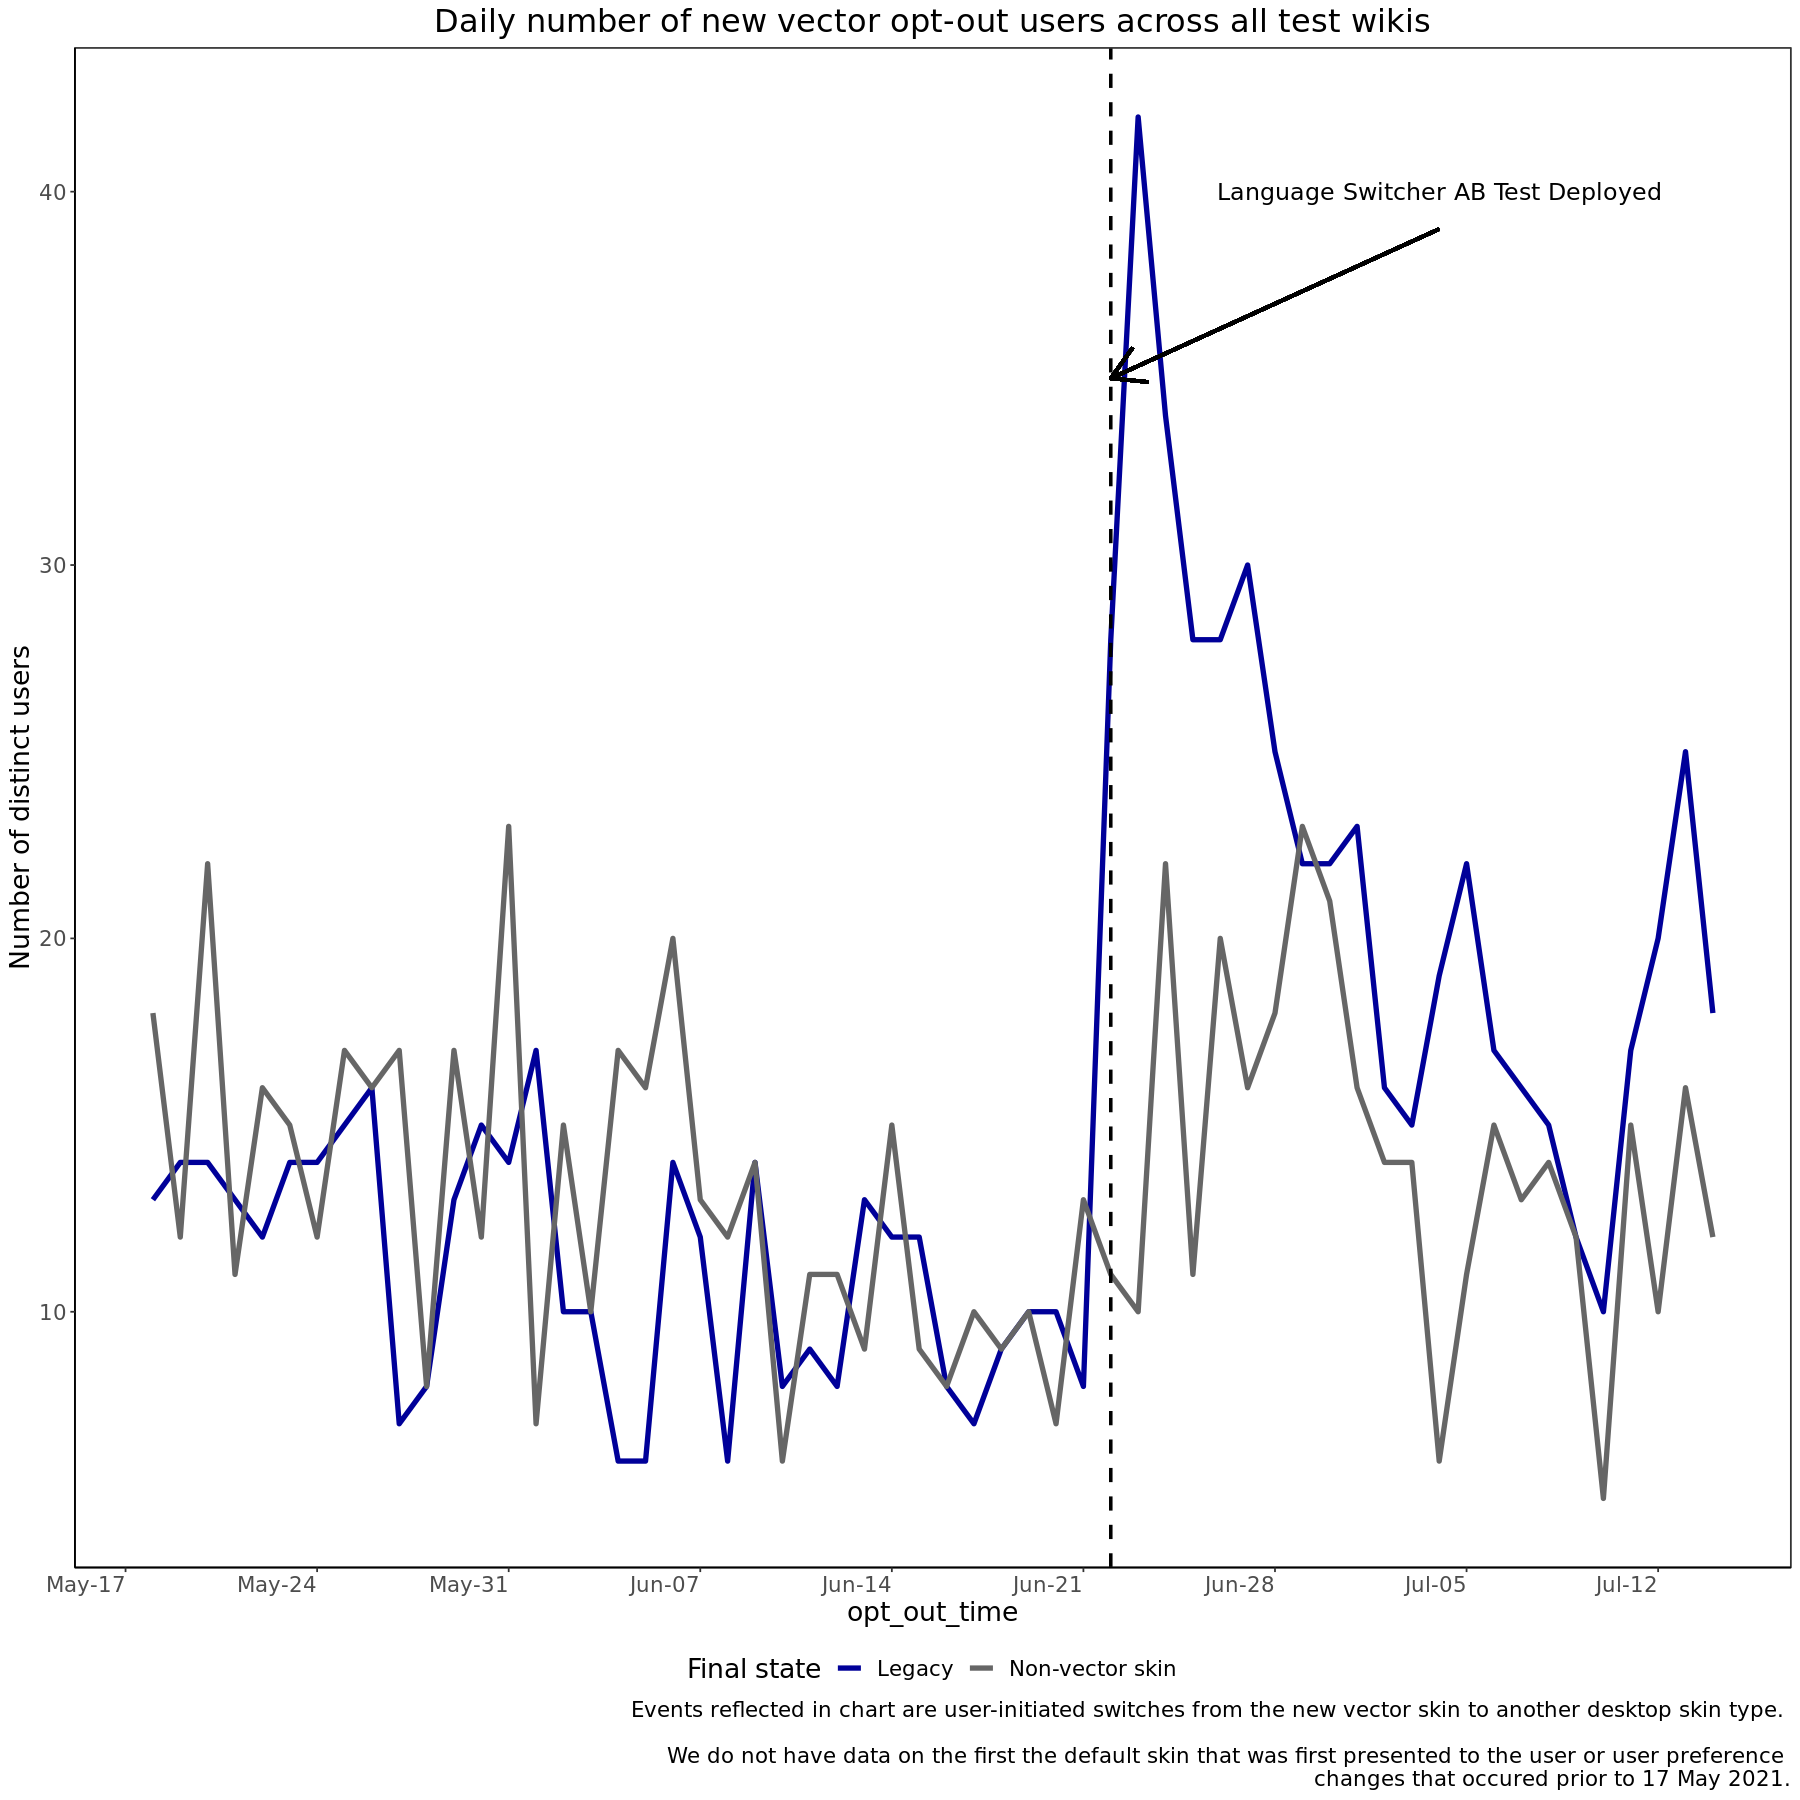

In [73]:
textaes <- data.frame(y = c(40),
                      x = as.Date(c('2021-07-04')),
                      lab = c("Language Switcher AB Test Deployed"))


p <- modern_vector_opt_outs_pilot_daily  %>%
        ggplot(aes(x = opt_out_time, y = total_users, color = skin_type)) +
        geom_line(size = 1.5) +
        geom_vline(xintercept = as.Date('2021-06-22'), linetype = 'dashed', size = 1) +
        geom_segment(aes(x = as.Date(c('2021-07-04')), y = 39, xend = as.Date('2021-06-22'), yend = 35),
                  arrow = arrow(length = unit(0.8, "cm")), size = 1, color = "black") +
        geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 5) +
        scale_x_date(date_labels = "%b-%d", date_breaks = "1 week", minor_breaks = NULL) +
        labs(title = "Daily number of new vector opt-out users across all test wikis",
           y = "Number of distinct users",
            caption = "Events reflected in chart are user-initiated switches from the new vector skin to another desktop skin type. 
            \n We do not have data on the first the default skin that was first presented to the user or user preference 
            changes that occured prior to 17 May 2021.") +
        theme_bw() +
        scale_color_manual(values= c("#000099", "#666666"), name = "Final state")  +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=16),
            legend.position="bottom",
            axis.text.x = element_text(hjust=1),
            axis.line = element_line(colour = "black"))
p

ggsave("Figures/daily_opt_outs_total.png", p, width = 16, height = 8, units = "in", dpi = 300)

Since 17 May 2021, there have been an average of about 29.6  distinct users across all test wiki that have opted out of the new vector skin.

The highest number of daily opt-outs logged so far was 56 distinct users on 24 June 2021. 

The highest number of daily opt-outs logged so far was 56 distinct users on 24 June 2021, a couple of days following the deployment of the language switcher AB test. The number of users opt-ing out quickly declined after that peak with closer to an average of 20 users opt'ng out per day towards mid-July. 

### Totals By Final Selected Skin States

In [271]:
modern_vector_opt_outs_byfinalstate <- modern_vector_opt_outs_pilot %>%
    mutate(all_users = n_distinct(user)) %>%
    group_by(final_state) %>%
    summarise(total_users = n_distinct(user),
             pct_users = paste0(round(total_users/all_users *100, 2), '%')) %>%
    distinct()

modern_vector_opt_outs_byfinalstate 

`summarise()` regrouping output by 'final_state' (override with `.groups` argument)



final_state,total_users,pct_users
<chr>,<int>,<chr>
minerva,269,17.77%
modern,212,14%
monobook,124,8.19%
timeless,189,12.48%
vector1,826,54.56%


Across all of the early adopter wikis, 54.6% of users that opt'd out of modern vector switched to legacy (`final_state = 'vector1'`) at least once during the reviewed timeframe. 

Note: It's possible that a user who switched their preference multiple times was recorded as switching to both legacy and other skin types within the reviewed time period. This is why the percents for each skin selection exceed 100 when summed.

## Opt-Outs by Test Wiki

In [272]:
# total number of opt-outs on each test wiki
opt_outs_bywiki <- modern_vector_opt_outs_pilot %>%
    group_by(wiki) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user)) 

opt_outs_bywiki

`summarise()` ungrouping output (override with `.groups` argument)



wiki,total_selections,total_users
<chr>,<int>,<int>
Basque Wikipedia,9,6
Bengali Wikipedia,36,23
French Wikipedia,908,537
French Wikitionary,32,23
German Wikivoyage,6,6
Hebrew Wikipedia,138,113
Korean Wikipedia,94,70
Persian Wikipedia,314,110
Portuguese Wikipedia,500,350


In [15]:
#total opt out excluding users that opt'd back in with skin type breakdowns
opt_outs_bywiki_exl_optin <- modern_vector_opt_outs_pilot %>%
    group_by(wiki, skin_type) %>%
    filter(is_opt_back_in != 1 ) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user)) 

opt_outs_bywiki_exl_optin

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,skin_type,total_selections,total_users
<chr>,<chr>,<int>,<int>
Basque Wikipedia,Legacy,3,3
Basque Wikipedia,Non-vector skin,6,3
Bengali Wikipedia,Legacy,23,17
Bengali Wikipedia,Non-vector skin,8,6
French Wikipedia,Legacy,422,289
French Wikipedia,Non-vector skin,422,263
French Wikitionary,Legacy,19,14
French Wikitionary,Non-vector skin,9,9
German Wikivoyage,Legacy,3,3


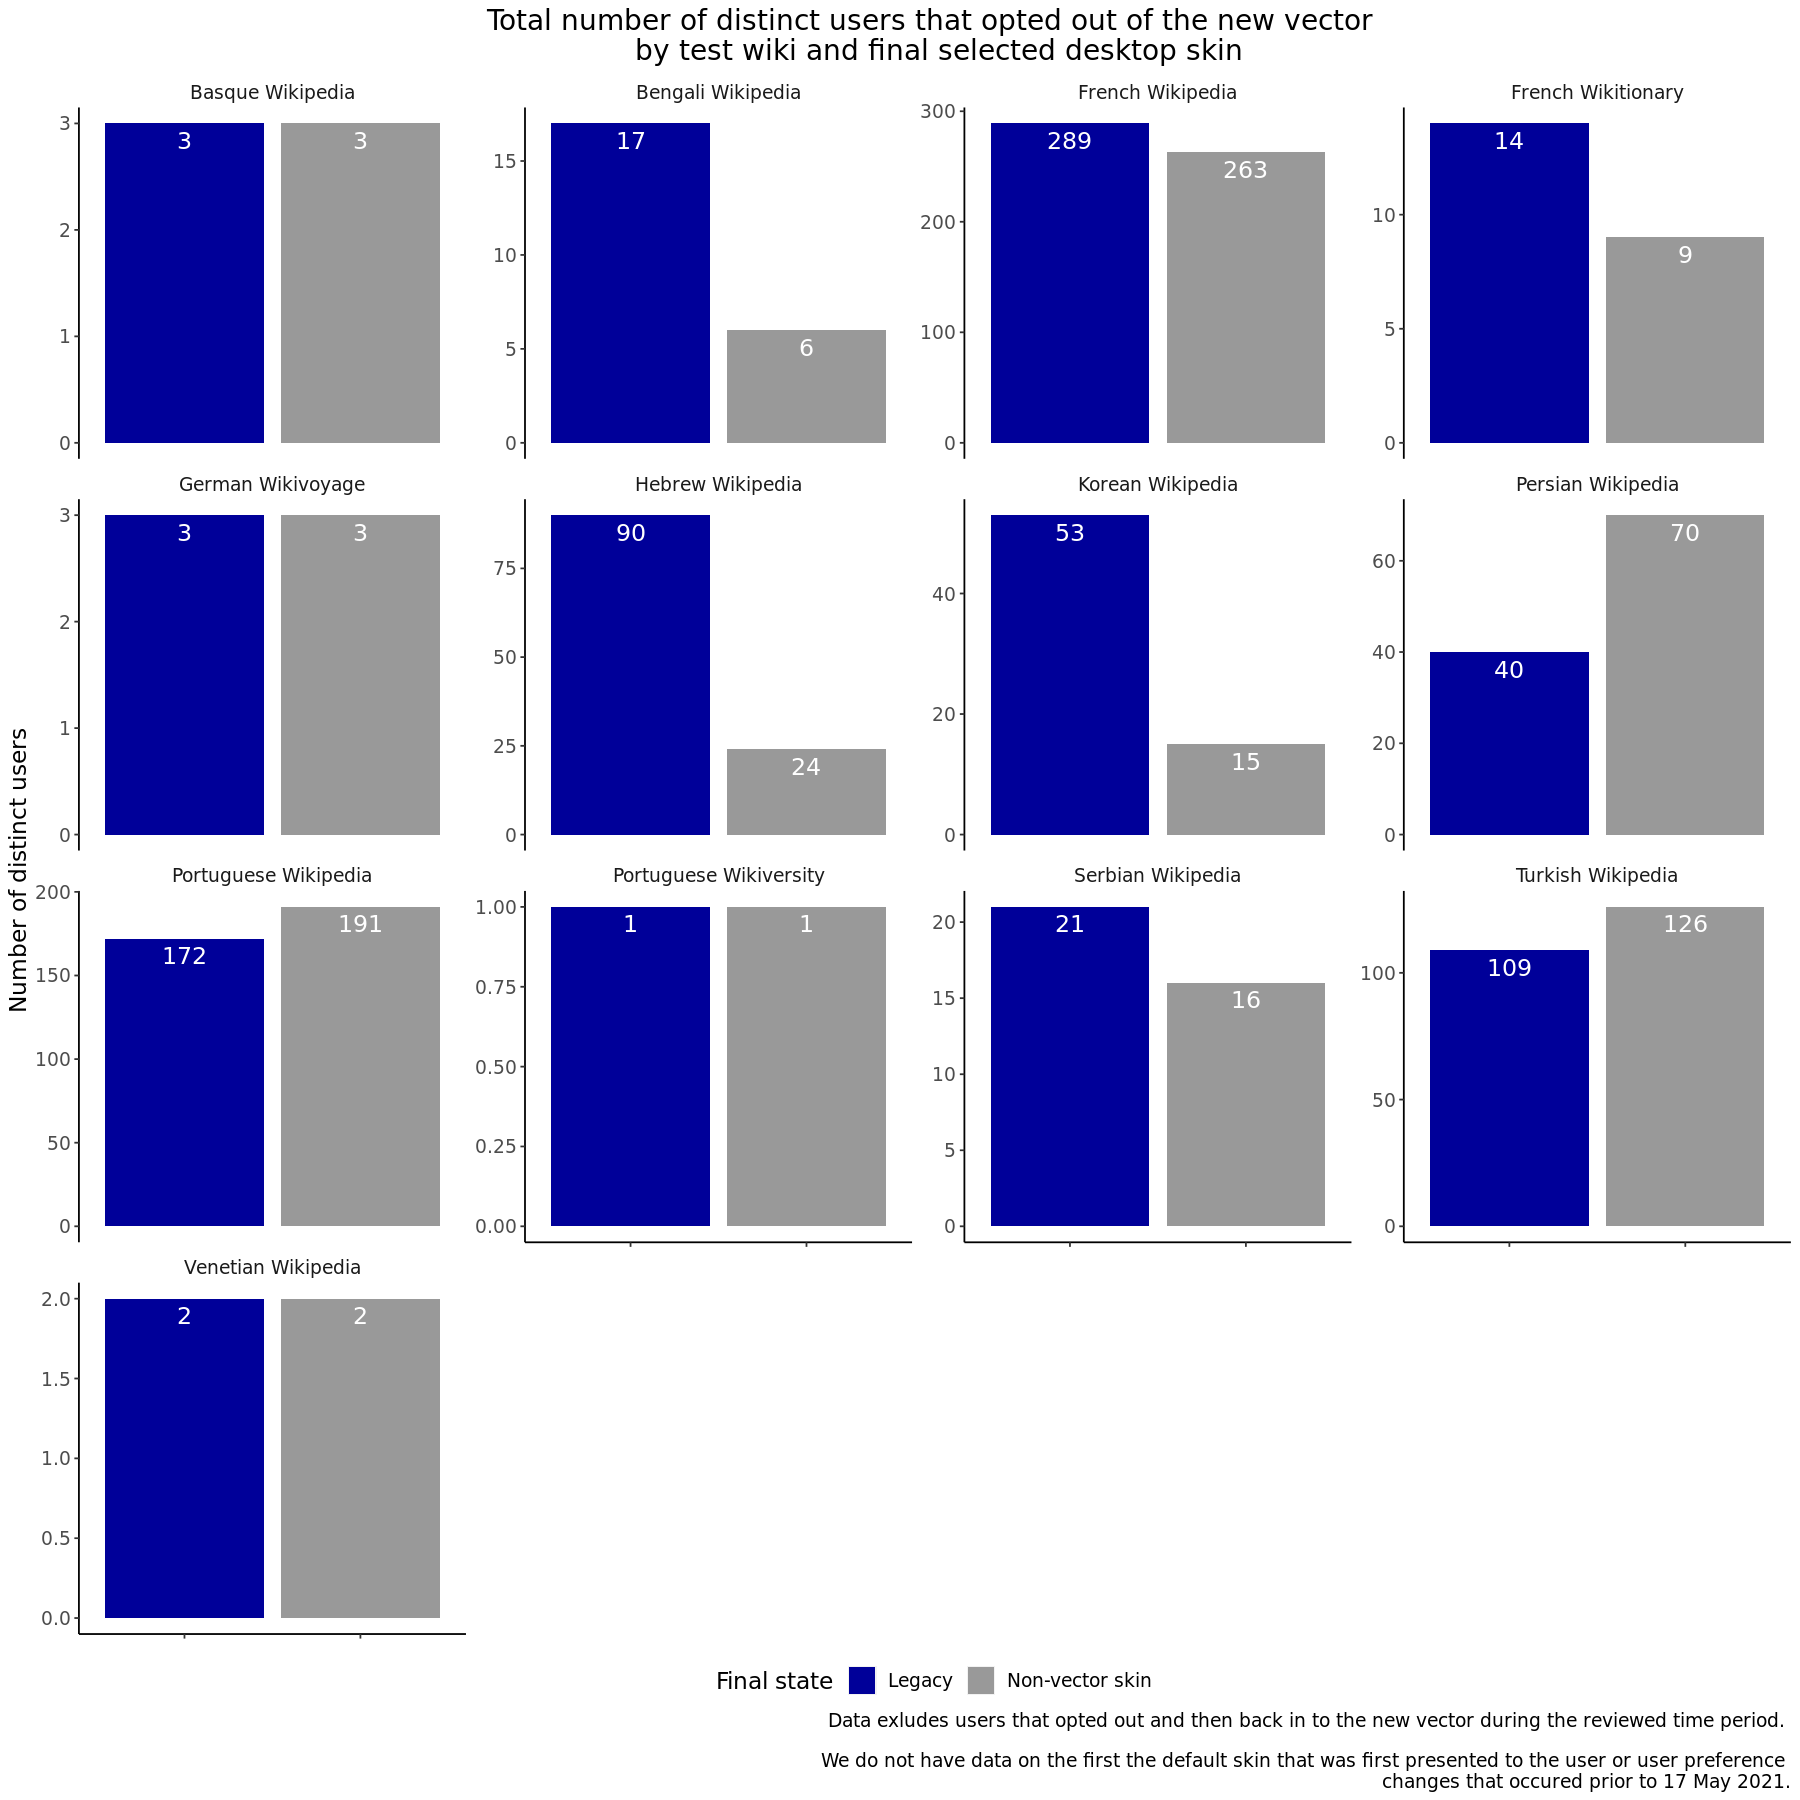

In [76]:
# Plot opt outs by wiki with skin state breakdowns

p <- opt_outs_bywiki_exl_optin %>%
        ggplot(aes(x =skin_type, y= total_users, fill = skin_type)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(total_users)), color = "white", vjust=1.5, size = 5) +
        facet_wrap(~wiki, scale = 'free_y') +
        labs (x = "Final selected skin state",
              y = "Number of distinct users",
             title = "Total number of distinct users that opted out of the new vector \n by test wiki and final selected desktop skin",
              caption = "Data exludes users that opted out and then back in to the new vector during the reviewed time period. 
            \n We do not have data on the first the default skin that was first presented to the user or user preference 
            changes that occured prior to 17 May 2021.") +
        scale_fill_manual(values= c("#000099", "#999999"), name = "Final state")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p

ggsave("Figures/opt_outs_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

There were more users that switched from the new vector skin to a non-vector desktop skin on Persian Wikipedia, Portuguese Wikipedia, and Turkish Wikipedia.

`summarise()` regrouping output by 'opt_out_time' (override with `.groups` argument)



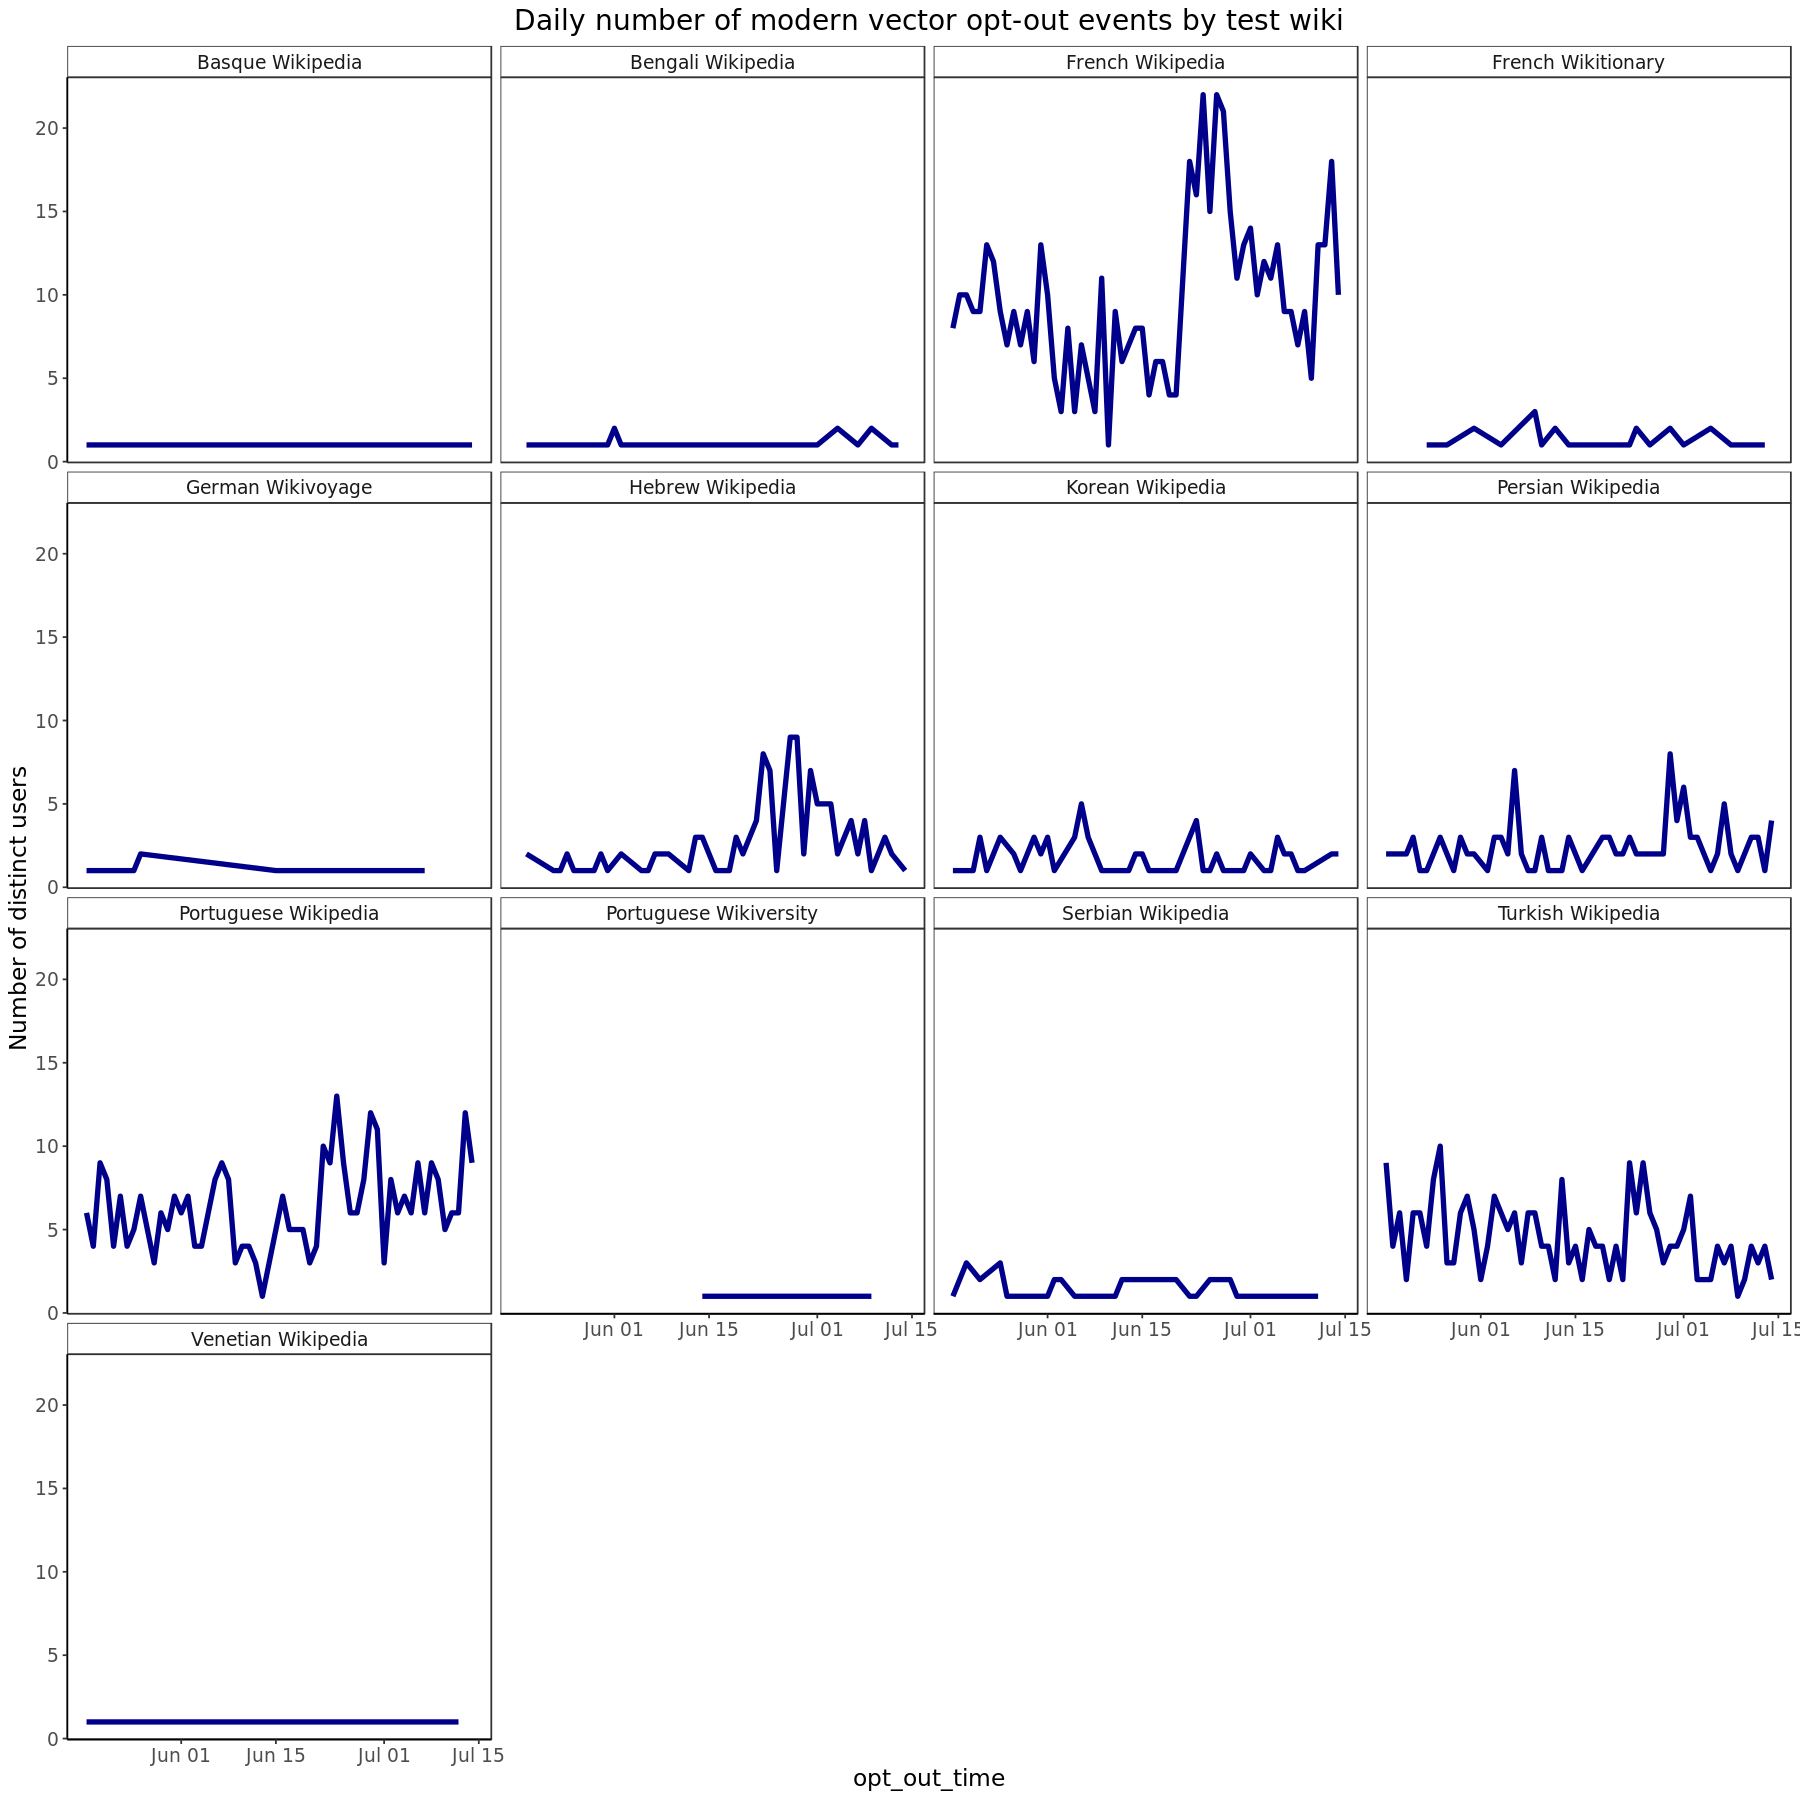

In [75]:


p <- modern_vector_opt_outs_pilot %>%
 # only look at modern vector opt-outs
        group_by(opt_out_time, wiki) %>%
        summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user)) %>%
        ggplot(aes(x = opt_out_time, y = total_users)) +
        geom_line(size = 1.5, color = "darkblue") +
        facet_wrap(~wiki, ncol = 4) +
        scale_x_date() +
        labs(title = "Daily number of modern vector opt-out events by test wiki",
           y = "Number of distinct users") +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")

p

ggsave("Figures/daily_opt_outs_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

Daily trends across each test wiki are roughly the same. A noticeable increase around June 22nd appears to occur specifically on French Wikipedia with some slight increases around that date for Portuguese Wikipedia and Hebrew Wikipedia as well.



## Opt-Outs by User Edit Count

In [ ]:
### Overall Numbers

In [77]:
modern_vector_opt_out_byeditcount <-modern_vector_opt_outs_pilot %>%
# remove users that opted back in
    filter(is_opt_back_in == 0)  %>%
    group_by(edit_count) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user)) 

modern_vector_opt_out_byeditcount

`summarise()` ungrouping output (override with `.groups` argument)



edit_count,total_selections,total_users
<fct>,<int>,<int>
0 edits,790,586
1-4 edits,292,239
5-99 edits,400,328
100-999 edits,135,122
1000+ edits,349,209


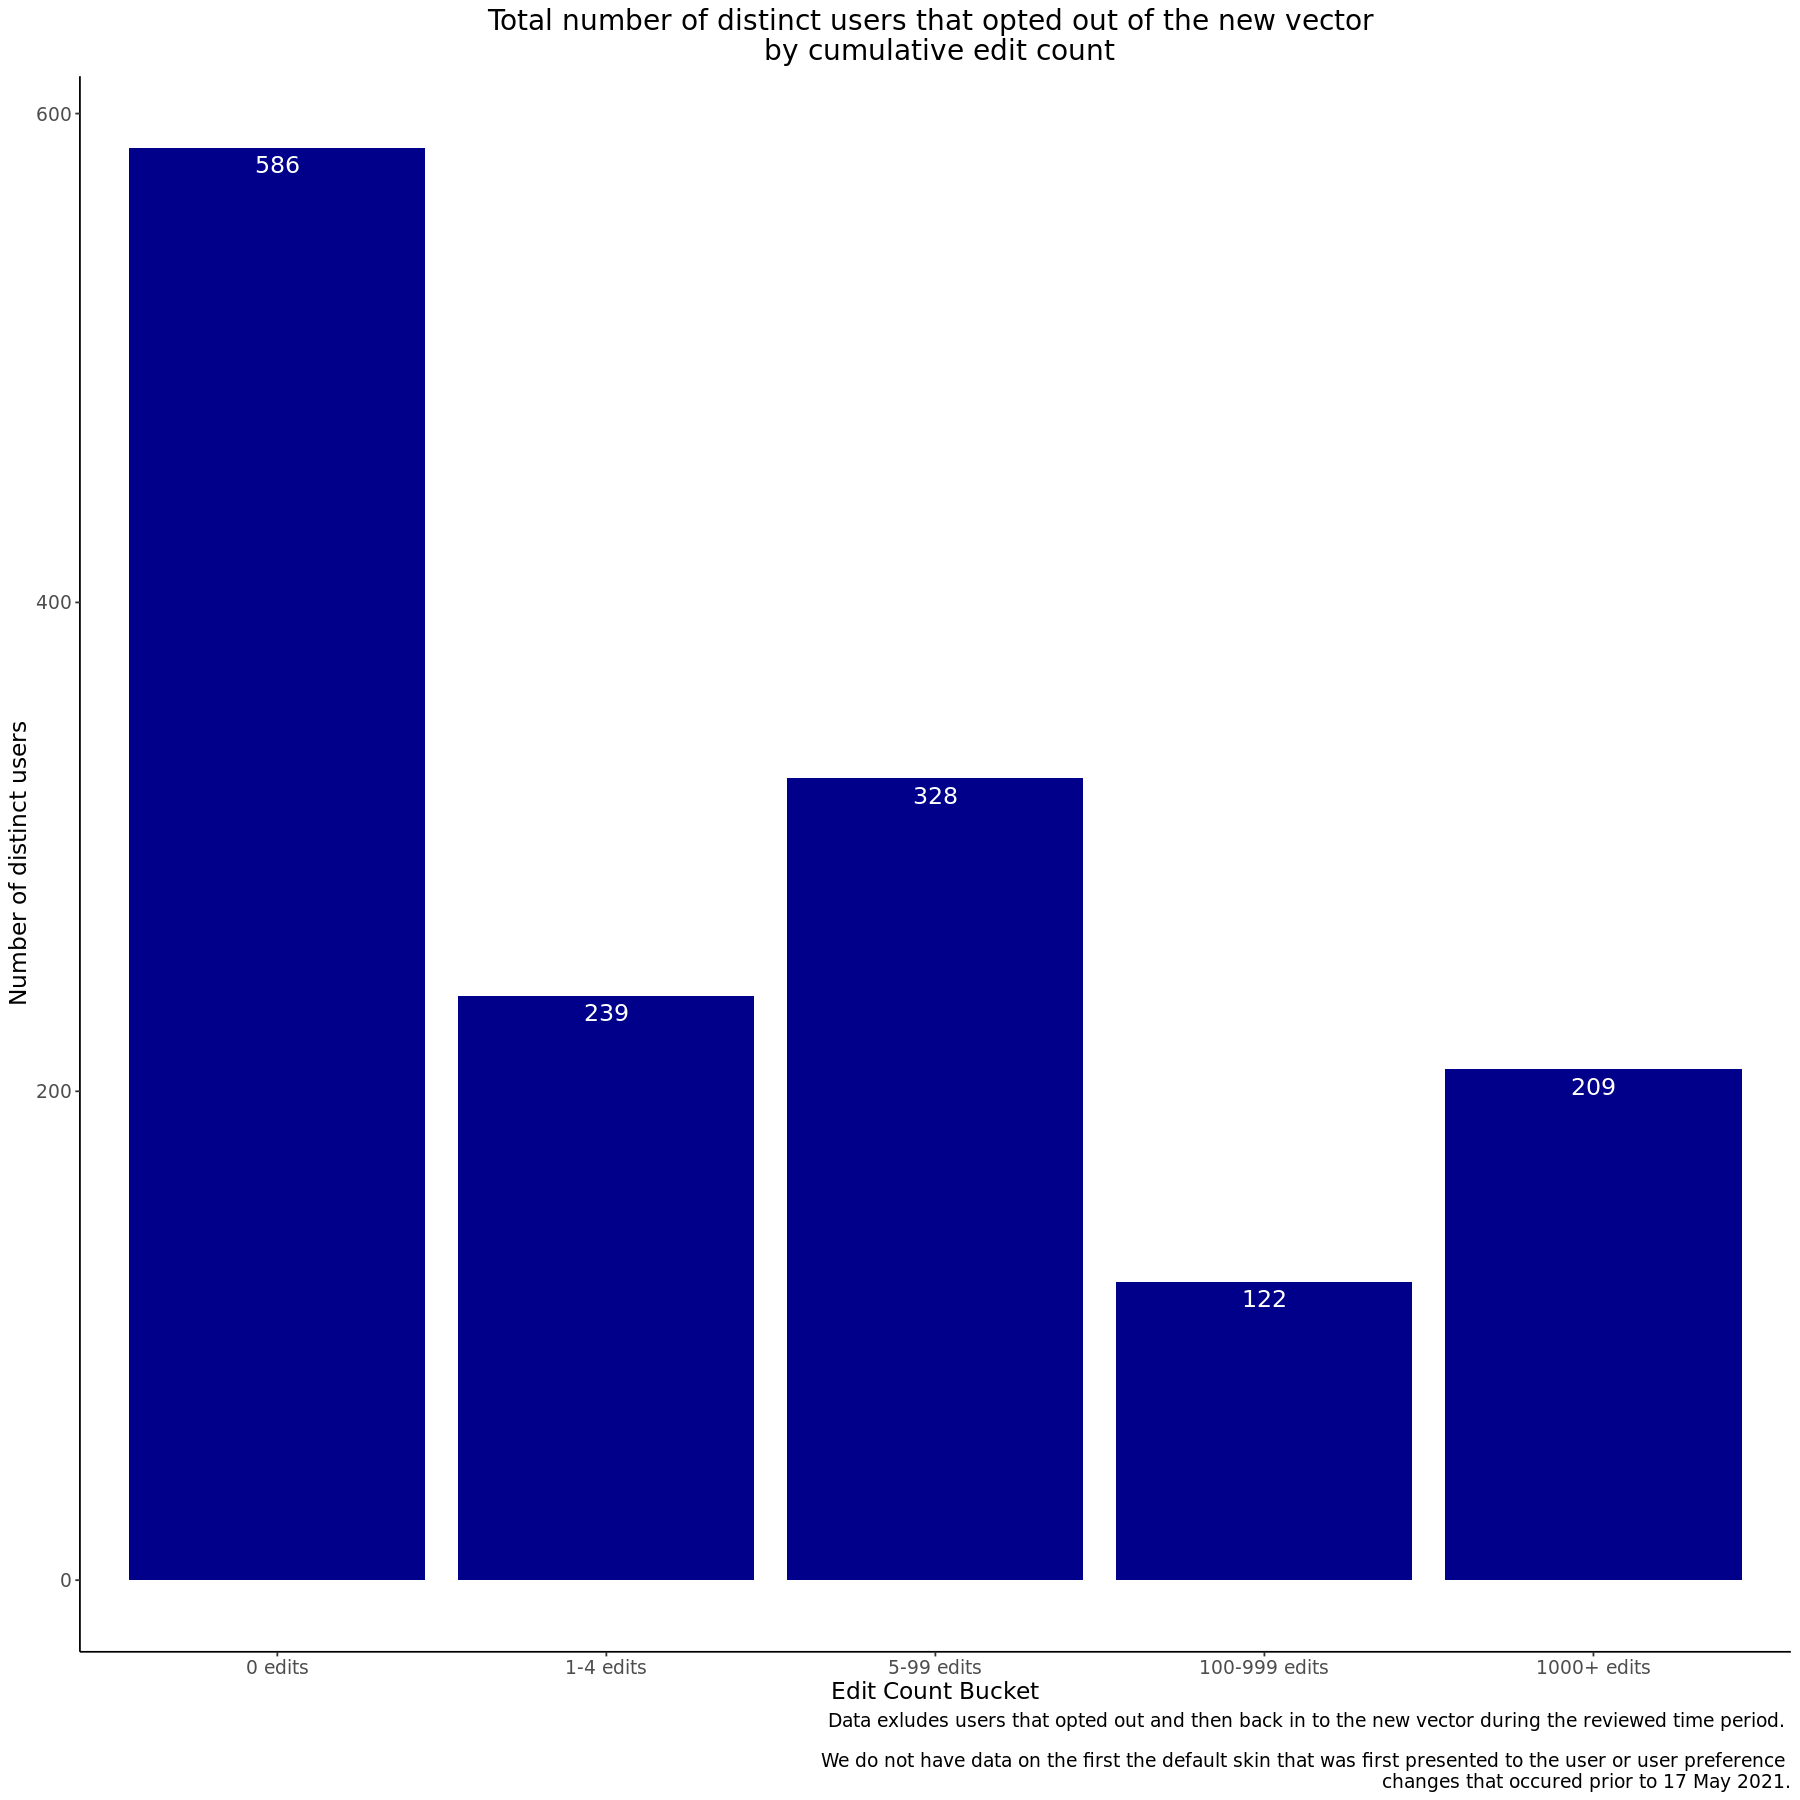

In [79]:
 # Plot total opt outs by edit count

p <- modern_vector_opt_out_byeditcount %>%
        ggplot(aes(x =edit_count, y= total_users)) +
        geom_col(position = 'dodge', fill = 'darkblue') +
        geom_text(aes(label = paste(total_users)), color = "white", vjust=1.5, size = 5) +
        labs (x = "Edit Count Bucket",
              y = "Number of distinct users",
             title = "Total number of distinct users that opted out of the new vector \n by cumulative edit count",
              caption = "Data exludes users that opted out and then back in to the new vector during the reviewed time period. 
            \n We do not have data on the first the default skin that was first presented to the user or user preference 
            changes that occured prior to 17 May 2021.") +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      
p

About 39% of users that opted out of the new vector did not have any recorded edits.

For editors that opted out, there is not a large discrepance between the various edit count buckets. There's slightly higher opt-out rate among junior editors (those with under 100 edits) compared to more experienced editors. 38% of junior editors opted out of the new vector skin compared to 22% of more experienced editors. 

### Users that switched multiple times by edit count

In [66]:
# Users that changed their preference multiple times by edit count
multiple_opt_out_users_byeditcount <- modern_vector_opt_outs_pilot %>%
    group_by(user) %>%
    mutate(total_selections = sum(num_selections)) %>%
    ungroup() %>%
    group_by(edit_count) %>%
    summarise(
        multiple_selection_users = n_distinct(user[total_selections > 1]),
        single_selection_users = n_distinct(user[total_selections == 1]),
        pct_multiple_pref_change = paste0(round(multiple_selection_users/ 
                        (multiple_selection_users + single_selection_users), 2), "%")) 
 
multiple_opt_out_users_byeditcount 

`summarise()` ungrouping output (override with `.groups` argument)



edit_count,multiple_selection_users,single_selection_users,pct_multiple_pref_change
<fct>,<int>,<int>,<chr>
0 edits,54,540,0.09%
1-4 edits,19,224,0.08%
5-99 edits,43,294,0.13%
100-999 edits,14,117,0.11%
1000+ edits,57,161,0.26%


Less than 1% of users in each edit count group switched their vector skin preference multiple times however, users with over 1000 edits had the highest percent of users that switched their preferences more than once during teh reviewed time period.

### Selected skin state by user edit count

`summarise()` regrouping output by 'edit_count' (override with `.groups` argument)



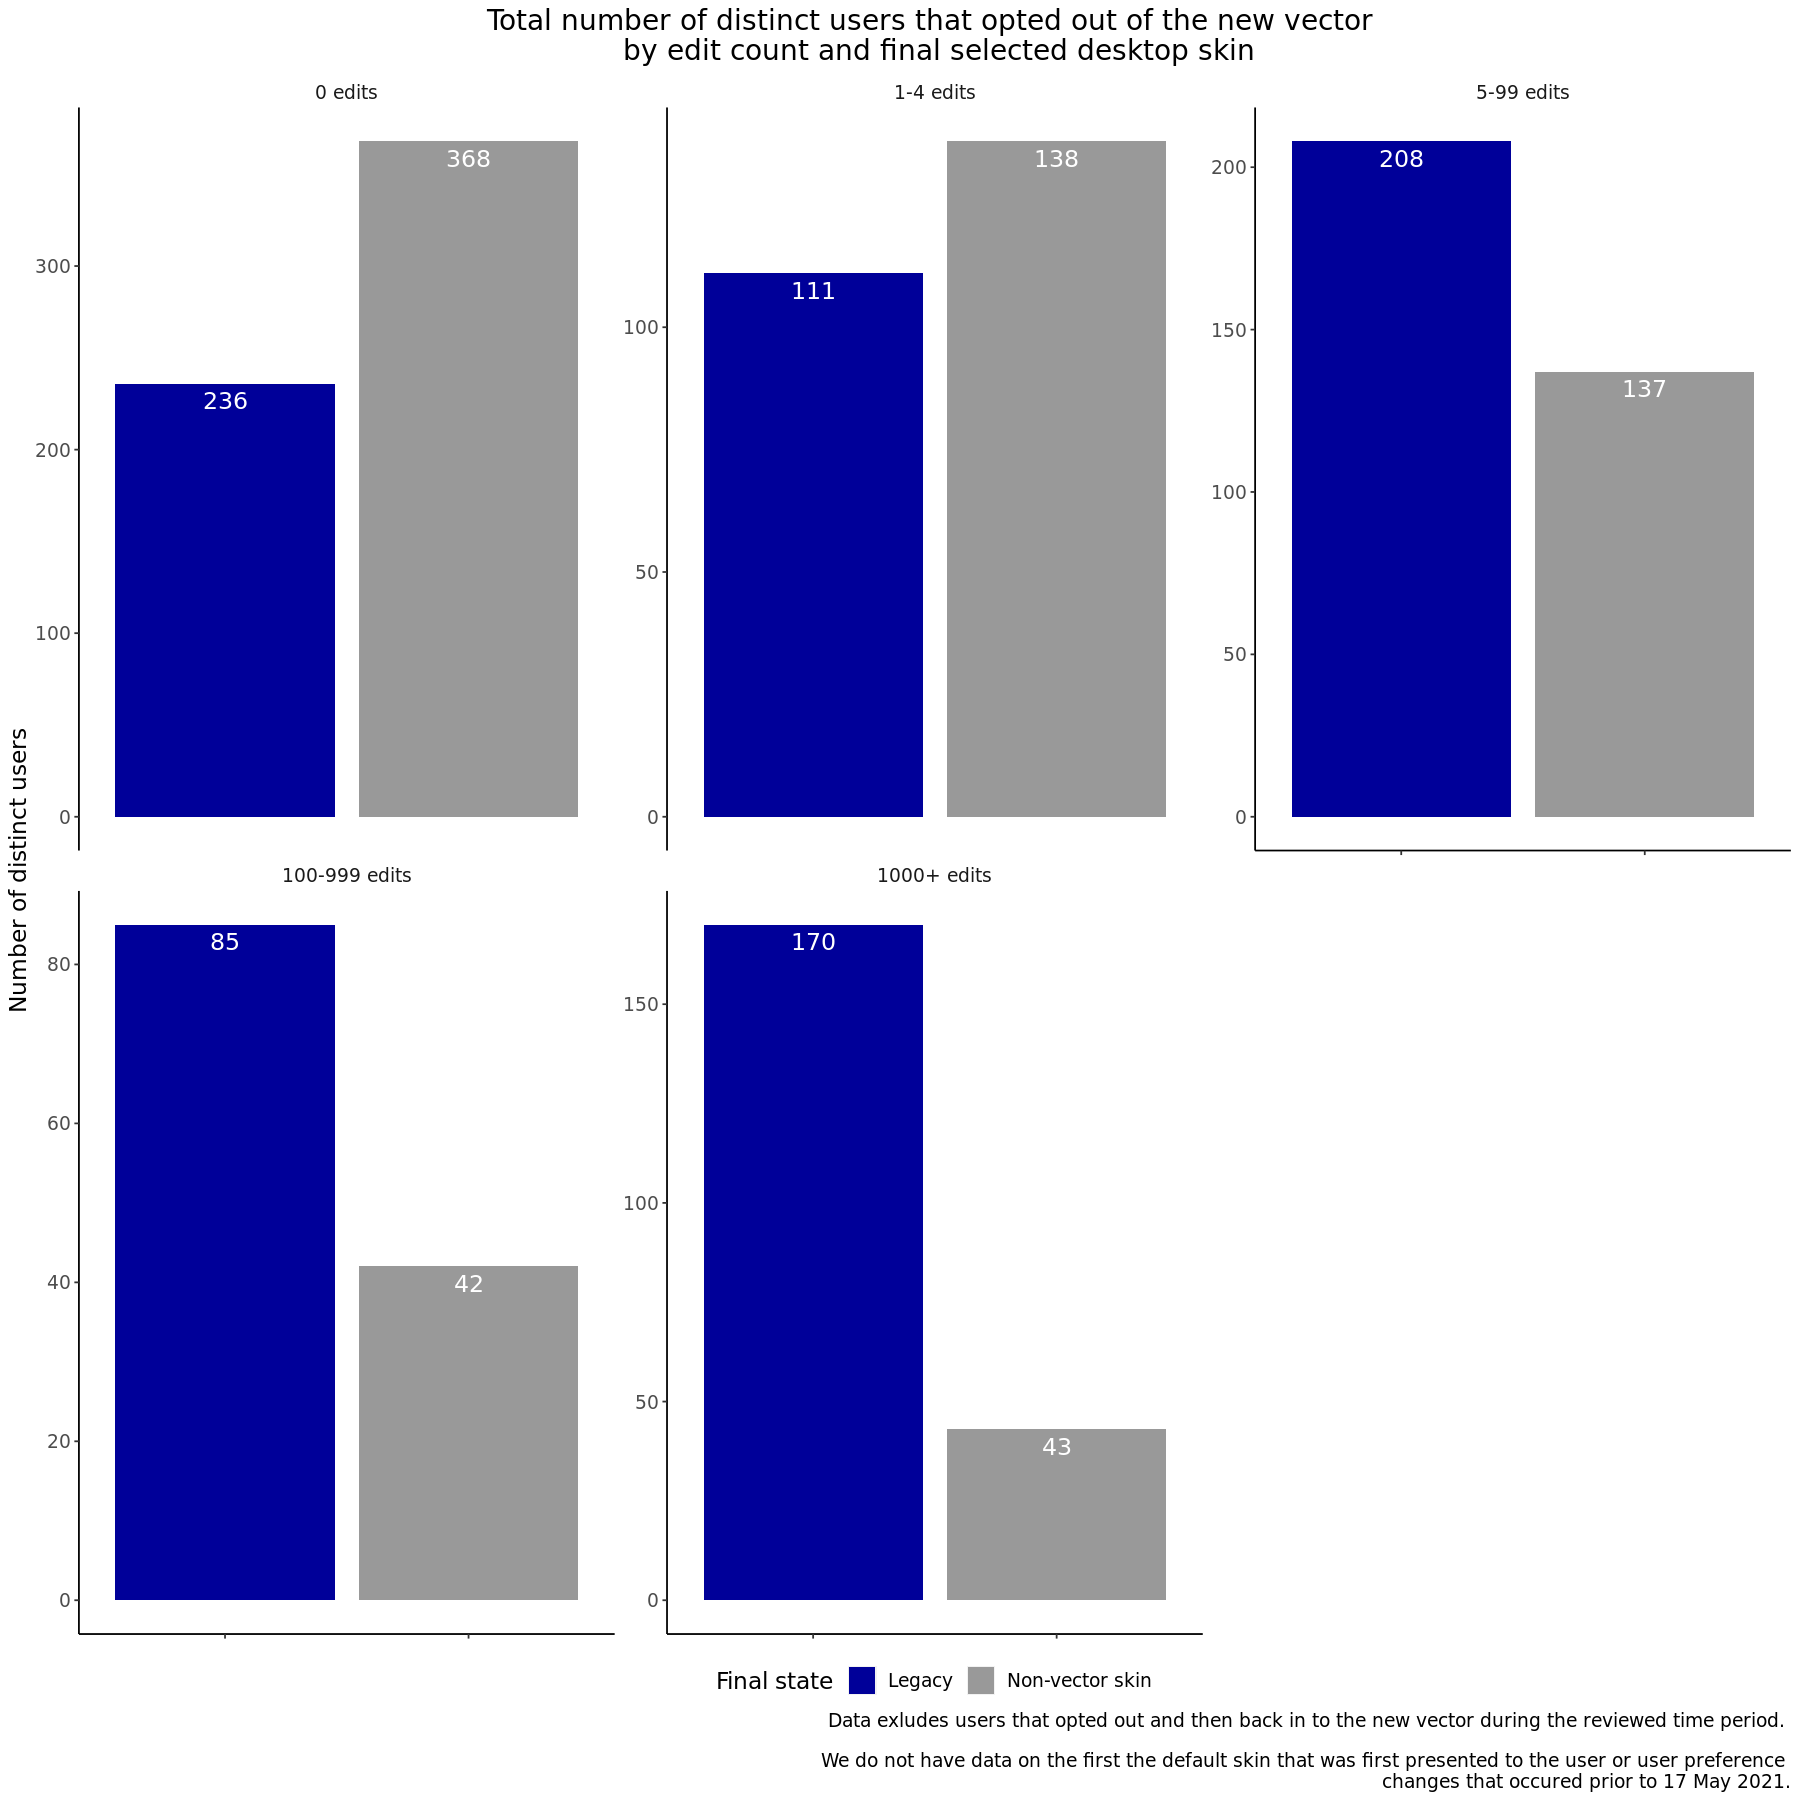

In [80]:
p <-modern_vector_opt_outs_pilot %>%
    filter (is_opt_back_in == 0) %>%
    group_by(edit_count, skin_type) %>%
    summarise(total_selections = sum(num_selections),
             total_users = n_distinct(user))  %>%
    ggplot(aes(x =skin_type, y= total_users, fill = skin_type)) +
        geom_col(position = 'dodge') +
        geom_text(aes(label = paste(total_users)), color = "white", vjust=1.5, size = 5) +
        facet_wrap(~edit_count, scale = 'free_y') +
        labs (x = "Final selected skin state",
              y = "Number of distinct users",
             title = "Total number of distinct users that opted out of the new vector \n by edit count and final selected desktop skin",
              caption = "Data exludes users that opted out and then back in to the new vector during the reviewed time period. 
            \n We do not have data on the first the default skin that was first presented to the user or user preference 
            changes that occured prior to 17 May 2021.") +
        scale_fill_manual(values= c("#000099", "#999999"), name = "Final state")  +
         theme(
            panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(),
            panel.background = element_blank(),
            strip.background =element_rect(fill="white"),
            plot.title = element_text(hjust = 0.5),
            text = element_text(size=14),
            axis.title.x=element_blank(),
            axis.text.x=element_blank(),
            axis.line = element_line(colour = "black"),
            legend.position = "bottom")
      

p
ggsave("Figures/opt_outs_byeditcount.png", p, width = 16, height = 8, units = "in", dpi = 300)

Editors with over 5 edits primarily switched to the legacy skin when they opted out of the new vector skin (79% of editors with over 1000 edits that opted out were recorded as switching to legacy), while editors with under 4 edits were more likely to switch to a non-vector skin during the reviewed time period (only 38% of users with no edits that opted out were recorded as switching to legacy)

